In [1]:
from IPython.core.display import display, HTML
import numpy as np
display(HTML("<style>.container { width:90% !important; }</style>"))

np.set_printoptions(linewidth=250, suppress=True)
np.set_printoptions(threshold=np.nan)

In [2]:
import numpy as np
import sys
import os
import cv2
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
import random
import torchvision
import PIL
import random
import pickle
import pprint as pprint

from dataset_processing import *
from UNet import *
from training_tools import *
from training import *

%load_ext autoreload
%autoreload 2

In [11]:
torch.cuda.empty_cache()

In [3]:
masks = pickle.load(open("cache/masks.p", "rb"))
oowl = pickle.load(open("cache/oowl.p", "rb"))
train_keys = pickle.load(open("cache/train_keys.p","rb"))
val_keys = pickle.load(open("cache/val_keys.p","rb"))
test_keys = pickle.load(open("cache/test_keys.p","rb"))

In [5]:
dataset_pickle_loc = "cache/oowl_val_tensor.pt"
annotation_pickle_loc = "cache/masks_val_tensor.pt"
dataset_T = torch.load(dataset_pickle_loc)
annotations_T = torch.load(annotation_pickle_loc)


In [ ]:
for i,x in enumerate(train_keys):
    print(i,x)

0


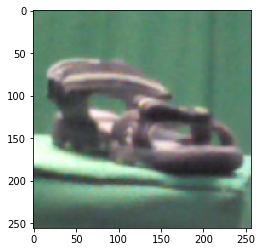

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


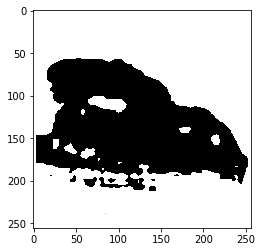

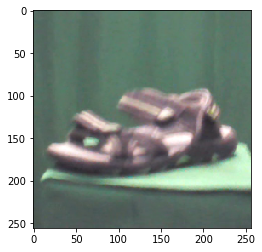

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


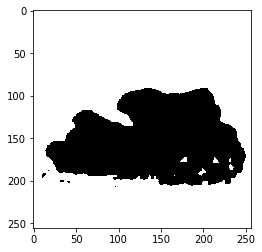

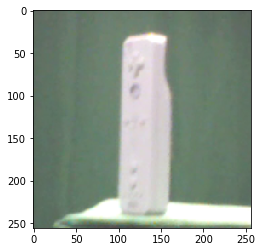

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


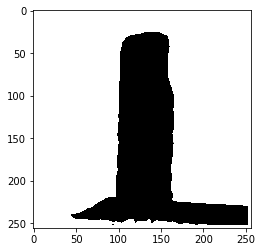

1


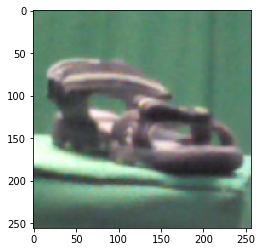

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


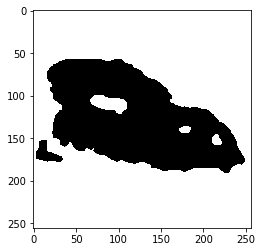

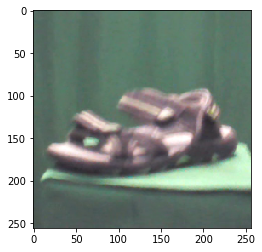

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


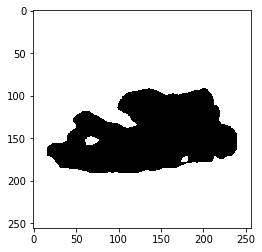

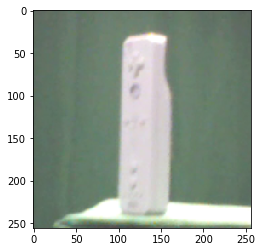

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


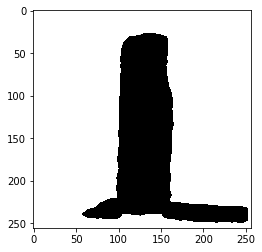

2


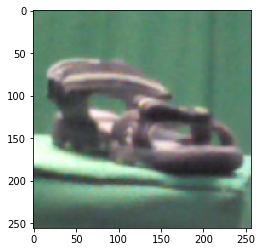

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


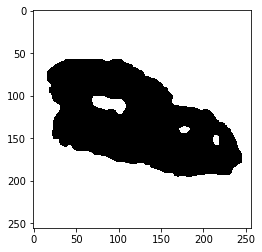

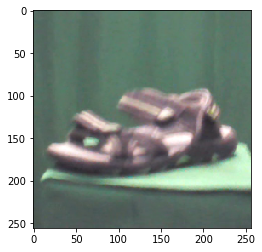

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


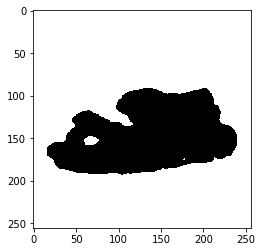

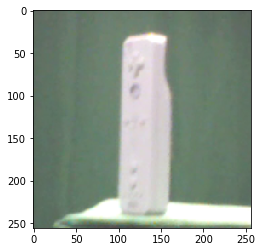

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


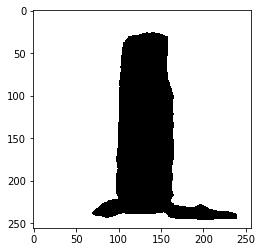

4


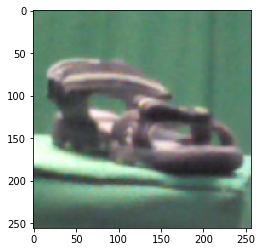

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


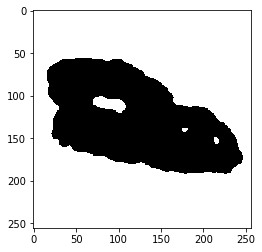

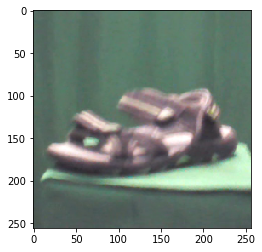

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


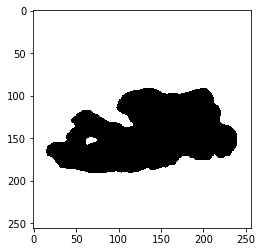

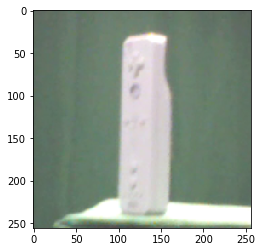

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


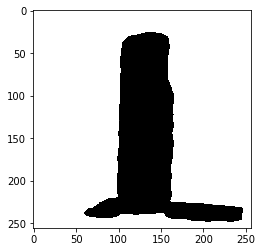

5


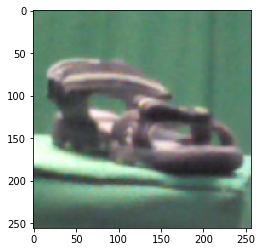

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


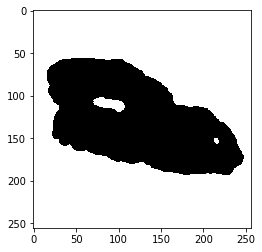

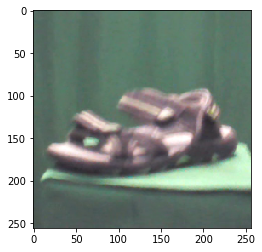

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


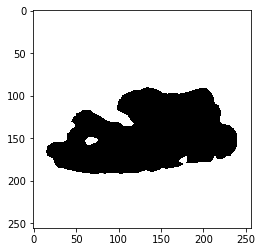

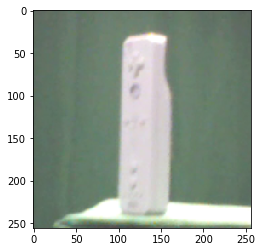

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


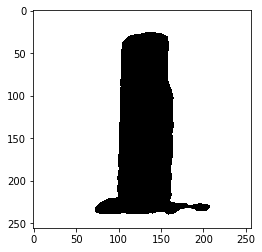

11


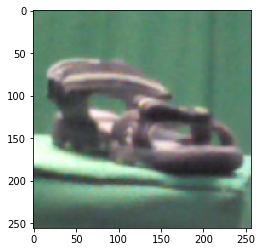

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


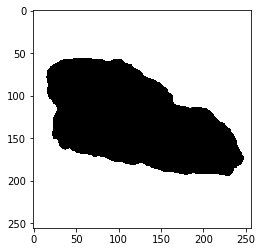

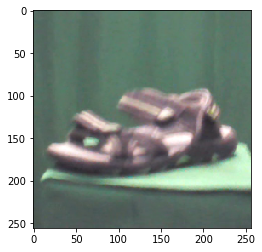

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


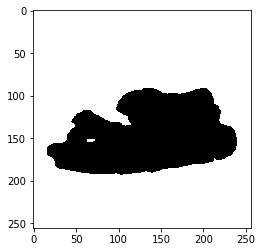

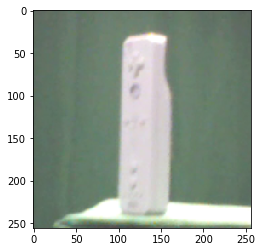

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


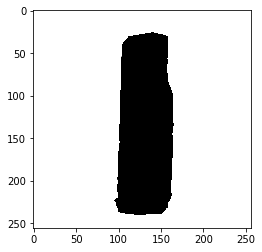

13


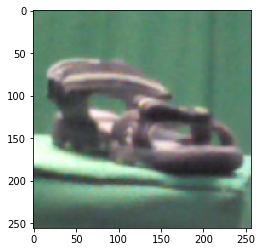

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


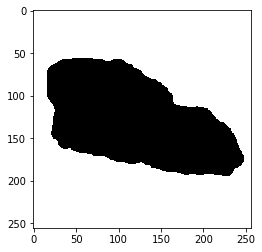

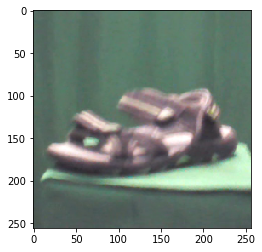

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


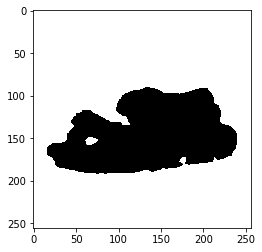

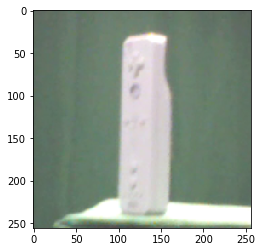

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


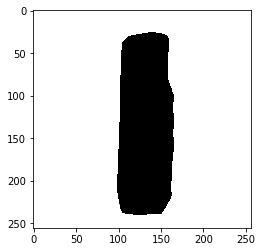

18


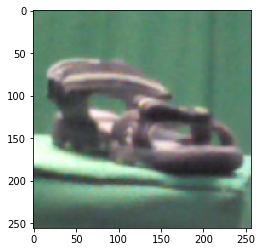

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


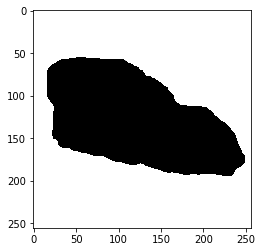

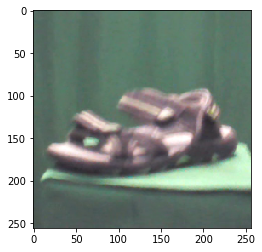

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


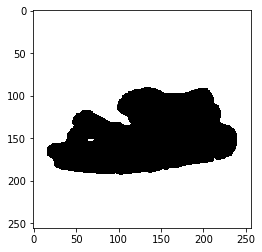

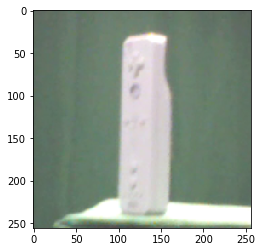

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


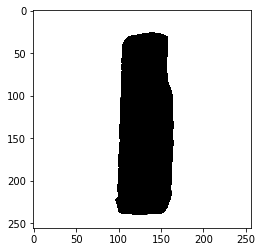

29


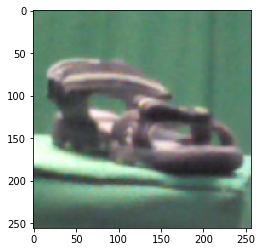

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


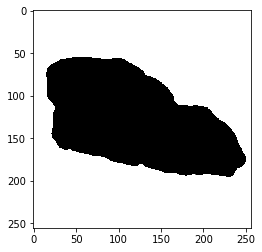

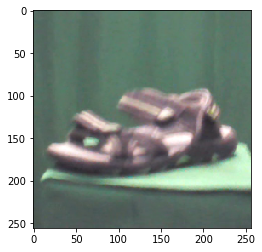

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


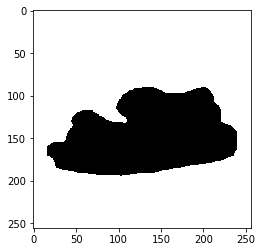

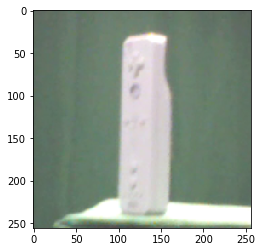

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


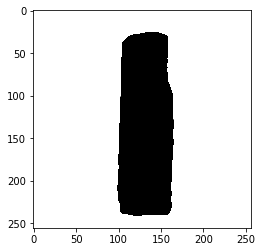

42


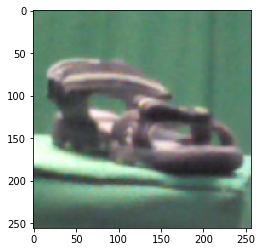

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


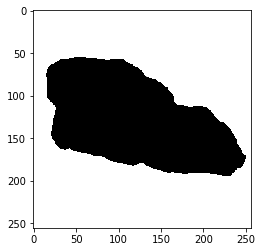

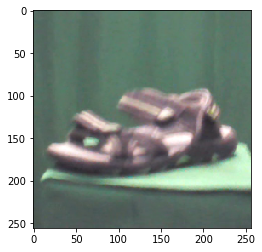

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


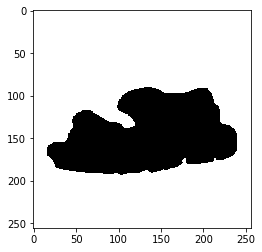

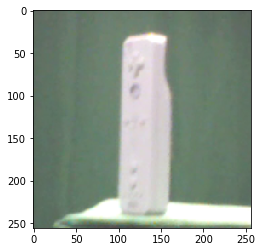

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


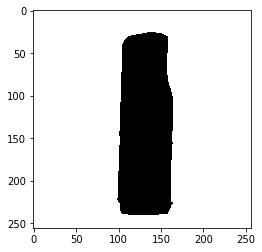

In [24]:
device = torch.device('cuda:5')

#for idx in [0,1,2]:
for idx in [0,1,2,4,5,11,13,18,29,42]:
    save_path = 'models/2018-09-27-14-42-07_fixed_val_dropout_fixed_aug_save_each_784106_highest_avg_iou_'+str(idx)
    unet = torch.load(save_path).to(device = device)
    print(idx)
    for key in [170, 1155, 1730]:
        
        predicted = see_seg(train_keys[key], unet, device)
        #gt = torch.tensor(masks[key]).unsqueeze(0)
        #show_pic(gt)

In [91]:
jitter = T.ColorJitter(brightness = 0.4, contrast = 0.4, saturation = 0.5, hue = 0.1)
horiz = T.RandomHorizontalFlip()
crop = T.RandomResizedCrop(256, scale=(0.95,1.0), interpolation = PIL.Image.NEAREST)
rotate = T.RandomRotation(3, expand = False, resample = PIL.Image.BILINEAR)
augumentation_tricks = T.Compose([jitter,horiz,crop,rotate])


#input: floattensors, img is 3x256x256 in [0,255], mask is 1x256x256 in [0,1] range
# outputs should be the same dimensions.
def augment(original_tensor_img, original_tensor_mask):
    
    # for ToPILImage to work properly, inputs must be bytetensors of shape 3x256x256, in range [0,255]
    original_tensor_img = original_tensor_img.to(dtype=torch.uint8)
    original_tensor_mask = original_tensor_mask.to(dtype=torch.uint8)
    original_tensor_mask = original_tensor_mask*255
    original_tensor_mask = torch.cat([original_tensor_mask, original_tensor_mask, original_tensor_mask]) 

    seed = random.randint(0,2**32)

    augmented_img = T.ToPILImage()(original_tensor_img)
    random.seed(seed)
    augmented_img = augumentation_tricks(augmented_img)
    augmented_img = torchvision.transforms.functional.affine(augmented_img,0,(0,0),1.06,0)
    augmented_img = T.ToTensor()(augmented_img)*255


    # converting to image first by multiplying by 255 and stacking x 3
   
    augmented_mask = T.ToPILImage()(original_tensor_mask)
    random.seed(seed)
    augmented_mask = augumentation_tricks(augmented_mask)
    augmented_mask = torchvision.transforms.functional.affine(augmented_mask,0,(0,0),1.06,0)
    augmented_mask = (T.ToTensor()(augmented_mask) > 0.1).type(torch.float)[0]


    return augmented_img, augmented_mask.unsqueeze(0)


24


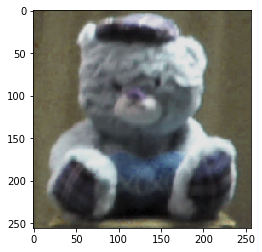

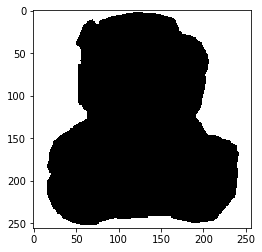

In [94]:
idx = 2
for idx in [24]:
    print(idx)
    img_T = dataset_T[idx].permute(2,0,1)
    mask_T = annotations_T[idx]
    #mask_T = annotations_T[0].to(dtype=torch.uint8)
    #print(img_T.size(), mask_T.size())

    aug_img, aug_mask = augment(img_T, mask_T)
    #print(aug_img.size(), aug_mask.size())

    aug_img = aug_img.detach().cpu().numpy().transpose(1,2,0).astype(int)
    aug_mask = aug_mask.detach().cpu().numpy().transpose(1,2,0).astype(int)
    aug_mask = np.concatenate([aug_mask, aug_mask, aug_mask],2)*255
    show_pic(aug_img)
    show_pic(aug_mask)

In [ ]:
pic_id = list(oowl.keys())[235]
pic = oowl[pic_id]
print(pic.shape)

test_img = dataset_T[55]
print(test_img.size())
show_pic(test_img.detach().cpu().numpy().astype(int))

t_input = test_img.permute(2,0,1)
n_input = torch.tensor(pic).permute(2,0,1)
#PIL = T.ToPILImage()()
PIL = T.ToPILImage()(t_input.to(dtype=torch.uint8))
back = T.ToTensor()(PIL)
show_pic((back.permute(1,2,0).numpy()*255).astype(int))
print(t_input.to(dtype=torch.float))
print(t_input.to(dtype=torch.uint8))

In [ ]:
img_id = test_keys[0]
img = oowl[img_id]
img_mask = np.array(masks[img_id])
show_pic(img)
show_pic(img_mask)

print(img.shape)
print(img_mask.shape)
img_T = torch.tensor(img.transpose(2,0,1), dtype=torch.uint8)
mask_T = torch.tensor(img_mask.transpose(2,0,1), dtype=torch.uint8)

print(mask_T.size())
aug_img, aug_mask = augument(img_T, mask_T)

aug_img = aug_img.detach().cpu().squeeze().numpy().transpose(1,2,0).astype(int)
aug_mask = aug_mask.detach().cpu().squeeze().numpy().transpose(1,2,0).astype(int)
show_pic(aug_img)
show_pic(aug_mask)

In [ ]:
save_path = "models/2018-09-22-18-47-06_AUGx8_349931"
device = torch.device('cuda:6')
unet = torch.load(save_path).to(device = device)

In [ ]:
def read_model_performance(model_log_path):
    log = open(model_log_path, 'r')
    lines = log.read().splitlines()
    performance_table = {}
    performance_table['val_loss']=[]
    performance_table['train_loss']=[]
    performance_table['val_IOU']=[]
    performance_table['train_IOU']=[]
    for line in lines:
        if "Epoch Validation Loss" in line:
            performance_table['val_loss'].append(float(line.split(' ')[-1]))
        elif "Epoch Training Loss" in line:
            performance_table['train_loss'].append(float(line.split(' ')[-1]))
        elif "Epoch Training Avg IOU" in line:
            performance_table['train_IOU'].append(float(line.split(' ')[-1]))
        elif "Epoch Validation Avg IOU" in line:
            performance_table['val_IOU'].append(float(line.split(' ')[-1]))       
    return performance_table
        
    

In [ ]:
performance_table=read_model_performance(save_path+'.txt')
pprint.pprint(performance_table)

In [ ]:
save_path_2 = "models/2018-09-22-18-48-45_AUGx8_0005_523041"
performance_table=read_model_performance(save_path+'.txt')
pprint.pprint(performance_table)

In [13]:
 def show_pic(in_pic):
    in_pic = np.array(in_pic)
    if len(in_pic.shape)== 4:
        in_pic = in_pic.squeeze(0)
    if in_pic.shape[0] == 1:

        orig_pic = in_pic
        pic = np.stack((orig_pic[0], orig_pic[0], orig_pic[0]),0)
        pic = pic*255
        pic = pic.transpose(1,2,0)
    else:
        pic = cv2.cvtColor(in_pic, cv2.COLOR_BGR2RGB)
    plt.imshow(pic)
    plt.show()
   

def see_seg(pic_id, model, device):
    
    image_dict = oowl
    #pic_id = list(image_dict.keys())[3000]
    #pic = torch.tensor(image_dict[pic_id],dtype=torch.float)
    pic = image_dict[pic_id]
    show_pic(pic)

    with torch.no_grad():
        net_input = np.expand_dims(pic, 0)
        net_input = net_input.transpose(0,3,1,2)
        net_input = torch.tensor(net_input)
        net_input = net_input.to(device=device, dtype=torch.float32)
        model.eval()
        predicted_mask = (model(net_input))
        predicted_mask_converted = predicted_mask.detach().cpu().numpy()
        show_pic(predicted_mask_converted)
    
    return predicted_mask

def get_IOU(predicted, gt):

    predicted_np = predicted.detach().cpu().numpy()
    gt_np = gt.detach().cpu().numpy()    
    intersection = np.sum(np.logical_and(predicted_np,gt_np))
    union = np.sum(np.logical_or(predicted_np, gt_np))
    return np.float(intersection)/union

def binarize_2(tensor):
    binarized = tensor.detach().cpu().numpy()
    #img_min = float(np.amin(binarized))
    #img_max = float(np.amax(binarized))
    #binarized = (binarized - img_min) / (img_max-img_min)
    std = np.std(binarized)
    binarized = (binarized - np.average(binarized))/std
    binarized = binarized > -0.5
    

    return torch.tensor(binarized.astype(int))

In [ ]:
for img in test_keys[60:61]:
    predicted = see_seg(img, unet, device)
    gt = torch.tensor(masks[img]).unsqueeze(0)
    show_pic(gt)
    print(get_IOU(predicted,gt))